**Name: Pei Tian (pt2632)** 


### Benchmark Result Screenshot {-}
![img](./img/benchmark-screenshot.jpg)

## Q1 {-}
Explain the rationale and expected consequence of only using the second half of the measurements for the computation of the mean execution time. Moreover, explain what type of mean is appropriate for the calculations, and why. 

**Solution:**

***Rationale***: 
Using only the second half of the measurements to compute the mean execution time primarily aims to capture the system's performance after it has reached a stable state, avoiding initial transient effects such as warming up or setup anomalies. This approach helps to focus on a more consistent and representative dataset, providing a clearer picture of the system's typical operational efficiency and minimizing the impact of any initial outliers or irregularities.

***Expected consequence***:
It is beneficial to reduce the impact of outliers on the mean. Using only the latter half of the measurements likely leads to a mean that better represents the system's performance under a typical load. If initial workload are abnormally high given the warm-up influence, excluding them helps in focusing on typical performance.

**Arithmetic mean** is appropriate for the calculations of mean execution time because each trail with same input size contribute equally to the final result.

## Q2 {-}

Draw a roofline model based on a peak performance of 200 GFLOPS and memory bandwidth of 30 GB/s. Add a vertical line for the arithmetic intensity. Plot points for the 10 measurements for the average results for each microbenchmark. The roofline model must be ”plotted” using matplotlib or an equivalent package.

Based on your plotted measurements, explain clearly whether the computations are compute or memory bound, and why. Discuss the underlying reasons for why these computations differ or don’t across each microbenchmark.

Lastly, identify any microbenchmarks that underperform relative to the roofline, and explain the algorithmic bottlenecks responsible for this performance gap.


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
log = "benchmark.log"

# Initialize variables
records = []
current_benchmark = ""
current_N = 0
current_R = 0
current_result = 0.0

In [3]:
def parse_log(log):
    # Process each line
    for line in open(log, 'r'):
        line = line.strip()
        if 'Bechmarking' in line:
            current_benchmark = line.split()[1].strip(':')
        elif 'N =' in line:
            parts = line.split(',')
            current_N = int(parts[0].split('=')[1].strip())
            current_R = int(parts[1].split('=')[1].strip(':'))
        elif 'Result:' in line:
            current_result = float(line.split(':')[1].strip())
        elif 'N:' in line:
            t_val = float(re.search(r'<T>: (.*?) sec', line).group(1))
            b_val = float(re.search(r'B: (.*?) GB/sec', line).group(1))
            f_val = float(re.search(r'F: (.*?) FLOP/sec', line).group(1))
            record = {
                'Benchmark': current_benchmark,
                'N': current_N,
                'R': current_R,
                'Result': current_result,
                'Time (sec)': t_val,
                'Bandwidth (GB/sec)': b_val,
                'FLOP/sec': f_val
            }
            records.append(record)

    # Create DataFrame
    df = pd.DataFrame(records)

    # Deduplicate by N and R
    df = df.drop_duplicates(subset=['N', 'R', 'Benchmark']).reset_index(drop=True)

    return df

In [4]:
df = parse_log(log)
df

,Benchmark,N,R,Result,Time (sec),Bandwidth (GB/sec),FLOP/sec
0,dp1,1000000,1000,1000000.0,0.001520,4.904,1.316279e+09
1,dp1,300000000,20,16777216.0,0.463242,4.825,1.295227e+09
2,dp2,1000000,1000,1000000.0,0.000468,15.948,4.281088e+09
3,dp2,300000000,20,67108864.0,0.232364,9.620,2.582319e+09
4,dp3,1000000,1000,1000000.0,0.000089,84.088,2.257222e+10
5,dp3,300000000,20,300000000.0,0.052341,42.706,1.146381e+10
6,dp4,1000000,1000,1000000.0,0.315912,0.024,6.331452e+06
7,dp4,300000000,20,16777216.0,95.669028,0.023,6.271686e+06
8,dp5,1000000,1000,1000000.0,0.000326,22.871,6.139364e+09
9,dp5,300000000,20,300000000.0,0.191655,11.663,3.130768e+09


### Roofline Plot {-}

In [5]:
GB2B = 2 ** 30
BANDWIDTH = 30 * GB2B # B/s
MAX_FLOPS = 200 * GB2B # FLOPS
balance_point = MAX_FLOPS / BANDWIDTH  # FLOP/Byte
ai_range = np.logspace(np.log10(0.01), np.log10(100), 100)
roofline = np.minimum(MAX_FLOPS, BANDWIDTH * ai_range)
balance_point

6.666666666666667

In [6]:
df['arithmetic_intensity'] = 2 * df['N'] / (2 * df['N'] * 4)  # FLOP/Byte

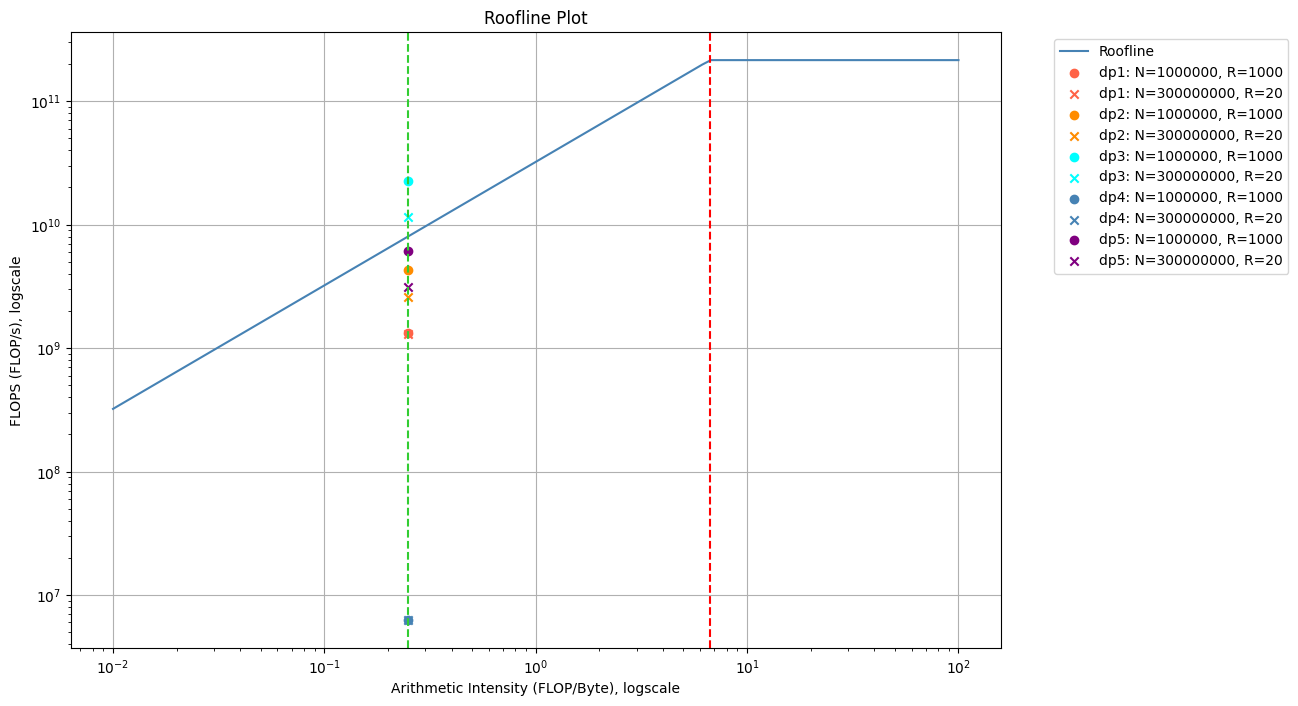

In [7]:
color_dict = {
    "dp1": "tomato",
    "dp2": "darkorange",
    "dp3": "aqua",
    "dp4": "steelblue",
    "dp5": "purple",
}
marker_dict = {
    1000000: "o",
    300000000: "x",
}
colors = df['Benchmark'].map(lambda x: color_dict[x])
markers = df['N'].map(lambda x: marker_dict[x])
x, y = df['arithmetic_intensity'], df['FLOP/sec']
labels = df.apply(lambda x: f"{x['Benchmark']}: N={x['N']}, R={x['R']}", axis=1)

def vis() -> plt.figure:
    plt.figure(figsize=(12, 8))
    plt.loglog(ai_range, roofline, label='Roofline', color='steelblue')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=colors[i], marker=markers[i], label=labels[i])

    plt.xlabel('Arithmetic Intensity (FLOP/Byte), logscale')
    plt.ylabel('FLOPS (FLOP/s), logscale')
    plt.axvline(balance_point, color='red', linestyle='--')
    plt.axvline(df['arithmetic_intensity'].max(), color='limegreen', linestyle='--')
    plt.title('Roofline Plot')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return plt

vis().show()

**Solution:** 

The computation is memory-bound, given all benchmark experiments located at the left side of red line. When arithmetic intensity (FLOP/Byte) is low, computations spend more time waiting for data from memory rather than performing actual floating-point operations.

***Reason:*** The reason why the computations are differ across each microbenchmark is that the algorithm and programming language used in each benchmark is different. 

***Underperform benchmarks***: `dp1.c` and `dp5.py`

***Algorithmic bottleneck***: 

- `dp1.c`: The algorithm use the brute-force approach to compute the dot product, which is not efficient for the memory access pattern. Because when call a function for each element in the vector, the memory access pattern is not coalesced, leading to poor memory utilization.
- `dp5.py`: The algorithm use the brute-force approach to compute the dot product, which is not efficient for the memory access pattern. Given the Python's overhead, the performance is even worse.

## Q3 {-}

Using the N = 300000000 simple loop as the baseline, explain the the difference in performance for the 5 measurements in the C and Python variants. Explain why this occurs by considering the underlying algorithms used.

Performance metrics of the 10 measurements in the C and Python variants.

### Performance Visualization {-}

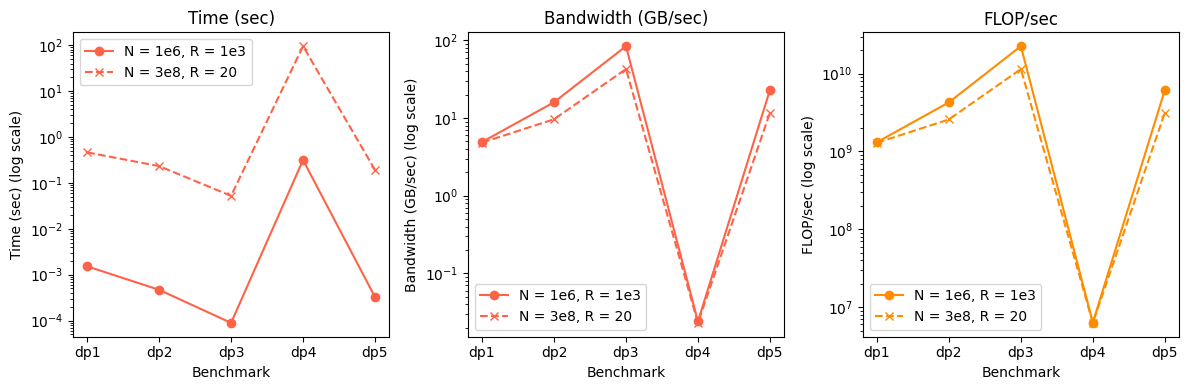

In [8]:
cols = ['Time (sec)', 'Bandwidth (GB/sec)', 'FLOP/sec']

def panel(df):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axs.flatten()):
        sub_df1 = df.query(f'N == 1000000 and R == 1000')
        sub_df2 = df.query(f'N == 300000000 and R == 20')
        sub_df1.plot(x='Benchmark', y=cols[i], kind='line', ax=ax, color=colors[i], marker='o')
        sub_df2.plot(x='Benchmark', y=cols[i], kind='line', ax=ax, color=colors[i], linestyle='--', marker='x')
        ax.set_title(cols[i])
        ax.set_yscale('log')
        ax.set_ylabel(cols[i] + ' (log scale)')
        ax.legend(['N = 1e6, R = 1e3', 'N = 3e8, R = 20'])
    plt.tight_layout()
    return plt

panel(df).show()

**Solution:**
The performance comparison: 
$$
{dp4} < {dp1} < {dp2} < {dp5} < {dp3}
$$

***Explanation***: 

- `dp3.c` is written in C with the usage of `MKL` library, which optimizes parallel processing for linear algebra operations based on the hardware architecture.
- `dp5.py` is written in `numpy` library, which is optimized for vectorized operations and parallel processing.
- `dp1.c` and `dp2.c` are written in C without using any optimization libraries, but `dp2.c` use unrolled loop to improve the performance.
- `dp4.py` is written in Python without using any optimization libraries, so the performance is the worst.

## Q4 {-}

Check the result of the dot product computations against the analytically calculated result. Explain your findings, and why the results occur. (Hint: Floating point operations are not exact.)

**Solution:**
***Analytically calculated result***: (All elements in each vector are 1)
$$
A \cdot B = \sum_{i=0}^{N-1} 1 = N
$$

***Execution result***:

- When N = 1000000, all the results are 1000000.
- When N = 300000000, some execution results are not exactly 300000000.

***Explanation***:
When doing element-wise operation on floating point numbers, the result is not exactly the expected result due to the precision limitation of floating point representation.